<a href="https://colab.research.google.com/github/gitzwey/SarcasmDetectionReddit/blob/main/Copy_of_NLP_Reddit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Reddit Sarcasm Detection

### Import Libraries

In [81]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np
import os
print(os.getcwd())

/content


### Import CSV

In [ ]:
training_csv_1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train-balanced-sarcasm.csv")

In [ ]:
training_csv_1["comment"] = training_csv_1["comment"].astype(str)

In [ ]:
training_csv_1.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


### Exploratory Data Analysis

In [ ]:
print(f"The total training data has {training_csv_1.author.nunique()} rows.")
training_csv_1.groupby("author").mean()["label"].value_counts()

The total training data has 256561 rows.


0.500000    251903
1.000000      2302
0.333333       770
0.400000       405
0.428571       268
             ...  
0.494949         1
0.477273         1
0.533333         1
0.494505         1
0.490385         1
Name: label, Length: 64, dtype: int64

##### The authors is mostly 0.5 probability of each label, might consider dropping it

In [ ]:
print(f"The total training data has {training_csv_1.subreddit.nunique()} rows.")
training_csv_1.groupby("subreddit").mean()["label"].value_counts()

The total training data has 14878 rows.


0.000000    5883
1.000000    2042
0.500000    1242
0.333333     585
0.250000     362
            ... 
0.524590       1
0.512048       1
0.132075       1
0.379574       1
0.522388       1
Name: label, Length: 1430, dtype: int64

##### Subreddit seems to provide more info than expected, should probably keep

In [ ]:
training_csv_1[["ups", "downs"]]

##### Notice how ups and downs seem to have a correlation? Lets test this theory out

In [ ]:
training_csv_1[training_csv_1["ups"].apply(lambda x: -1 if x <= -1 else 0) != training_csv_1["downs"]]

##### Only 6.1% does not follow the rules, is downs worth keeping? Debatable I guess

### Build model using Comment Column only (Unigram Model)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [ ]:
## Better abstraction

class sklearnClassifier:
    def __init__(self, model, data, label, fitBool = True):
        self.model = model
        if fitBool: self.fit(data, label)
            
    def fit(self, data, label):
        self.model.fit(data, label)
    
    def score(self, X, y_true):
        y_pred = self.model.predict(X)
        print(f"Accuracy score: {accuracy_score(y_true, y_pred)}")
        print(f"Recall score: {recall_score(y_true, y_pred)}")
        print(f"Precision score: {precision_score(y_true, y_pred)}")
        print(f"F1 score: {f1_score(y_true, y_pred)}")

In [ ]:
training_csv_1["comment"] = training_csv_1["comment"].apply(lambda x: x.lower())

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    training_csv_1["comment"], 
    training_csv_1["label"], 
    test_size = 0.2
)

In [ ]:
def create_ngram_vectorizer(text_train, ngram_range = (1,1), **kwargs):
    vectorizer = CountVectorizer(ngram_range = ngram_range, **kwargs)
    vectorizer.fit(text_train)
    return vectorizer

In [ ]:
unigram_vectorizer = create_ngram_vectorizer(X_train)

In [ ]:
X_train_transformed = unigram_vectorizer.transform(X_train)
X_val_transformed = unigram_vectorizer.transform(X_val)

In [ ]:
base_classifier = sklearnClassifier(SGDClassifier(), X_train_transformed, y_train)

In [ ]:
print("Training: ")
base_classifier.score(X_train_transformed, y_train)
print("Validation: ")
base_classifier.score(X_val_transformed, y_val)

### Now what? Bigrams and Trigrams, LETZ GO!!!

In [ ]:
# for i in range(1, 3): # Trigram is a bit slow so we'll bring that back later
#     igram_vectorizer = create_ngram_vectorizer(X_train, ngram_range = (1,i))
#     X_train_transformed = igram_vectorizer.transform(X_train)
#     X_val_transformed = igram_vectorizer.transform(X_val)
    
#     base_classifier = sklearnClassifier(SGDClassifier(), X_train_transformed, y_train)
    
#     print("Training: ")
#     base_classifier.score(X_train_transformed, y_train)
#     print("Validation: ")
#     base_classifier.score(X_val_transformed, y_val)
#     print()

### Using TFIDF instead of just counting

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
def create_tfidf_ngram_vectorizer(text_train, ngram_range = (1,1), **kwargs):
    vectorizer = TfidfVectorizer(ngram_range = ngram_range, **kwargs)
    vectorizer.fit(text_train)
    return vectorizer

In [ ]:
# for i in range(1,3):
#     tfidf_igram_vectorizer = create_tfidf_ngram_vectorizer(X_train, ngram_range = (1,i))
#     X_train_transformed = tfidf_igram_vectorizer.transform(X_train)
#     X_val_transformed = tfidf_igram_vectorizer.transform(X_val)
    
#     base_classifier = sklearnClassifier(SGDClassifier(), X_train_transformed, y_train)
    
#     print("Training: ")
#     base_classifier.score(X_train_transformed, y_train)
#     print("Validation: ")
#     base_classifier.score(X_val_transformed, y_val)
#     print()

### Vector Representation Test

In [ ]:
### Abstraction for easier work
class EmbeddingTechniques:
    def __init__(self, method):
        self.transformMethod = method
    
    def transform(self, X):
        return self.transformMethod(X)

In [ ]:
class EmbeddingTester:
    def __init__(self, sklearnmodel):
        self.list_of_techniques = {}
        self.tokenized = {}
        self.model = sklearnmodel
        
    def addEmbeddingTechniques(self, key, method, tokenized = False):
        self.list_of_techniques[key] = method
        self.tokenized[key] = tokenized
        
        
    def testModel(self, X_train_transformed, y_train_true, X_test_transformed, y_test_true, text = None):
        if text is not None: print(text)
        self.model.fit(X_train_transformed, y_train_true)
        print("Training: ")
        self.model.score(X_train_transformed, y_train_true)
        print()
        print("Validation: ")
        self.model.score(X_test_transformed, y_test_true)
        print("-" * 80)
        
    def test(self, X_train_untransformed, y_train_true, X_test_untransformed, y_test_true,
            X_train_tokenized, X_test_tokenized):
        for key, val in self.list_of_techniques.items():
            if self.tokenized[key]:
                X_train_transformed = val.transform(X_train_tokenized)
                X_test_transformed = val.transform(X_test_tokenized)
            else:
                X_train_transformed = val.transform(X_train_untransformed)
                X_test_transformed = val.transform(X_test_untransformed)
            self.testModel(X_train_transformed, y_train_true, X_test_transformed, y_test_true, text = key)

In [ ]:
tester = EmbeddingTester(base_classifier)
tester.addEmbeddingTechniques(
    "Count Vectorizer(No stopwords removal)", 
    create_ngram_vectorizer(X_train, ngram_range = (1,2))
)

tester.addEmbeddingTechniques(
    "TFIDF Vectorizer(No stopwords removal)", 
    create_tfidf_ngram_vectorizer(X_train, ngram_range = (1,2))
)

tester.addEmbeddingTechniques(
    "Count Vectorizer(With stopwords removal)", 
    create_ngram_vectorizer(X_train, ngram_range = (1,2), stop_words='english')
)

tester.addEmbeddingTechniques(
    "TFIDF Vectorizer(With stopwords removal)", 
    create_tfidf_ngram_vectorizer(X_train, ngram_range = (1,2), stop_words='english')
)

In [ ]:
## Thanks Rama, like srsly
from gensim.models import Word2Vec
from nltk.tokenize import TreebankWordTokenizer

In [ ]:
vector_size = 128
word_tokenizer = TreebankWordTokenizer()

X_train_tokenized = [word_tokenizer.tokenize(text) for text in X_train]
X_val_tokenized = [word_tokenizer.tokenize(text) for text in X_val]

model = Word2Vec(X_train_tokenized, min_count = 1, vector_size= vector_size, workers = 3, window = 3, sg = 1)

In [ ]:
def transform(X_tokenized):
    temp = np.matrix(
        [np.mean([model.wv[i] if i in model.wv else np.array([0.0] * vector_size, dtype=np.float64) for i in tokens], axis = 0) for tokens in X_tokenized],
        dtype=np.float64
    )
    return temp

In [ ]:
tester.addEmbeddingTechniques(
    "word2Vec Mean Embedding", 
    EmbeddingTechniques(transform),
    True
)

tester.test(X_train, y_train, X_val, y_val, X_train_tokenized, X_val_tokenized)

## Feature Engineering

### Imports

In [82]:
from nltk.tokenize import TreebankWordTokenizer, WordPunctTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk

nltk.download('stopwords')
porter_stemmer = PorterStemmer()
word_tokenizer = TreebankWordTokenizer()
word_tokenizer2 = WordPunctTokenizer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
stopwords.words('english')

In [83]:
## tokenize cols
## Define function to remove stopwords and tokenize comments and or parent_comments
def create_stopwords_dict():
  stopwords_dict = {}
  for word in set(stopwords.words('english')):
    stopwords_dict[word] = True
  return stopwords_dict

stop_words_dict = create_stopwords_dict()


def remove_stopwords_and_tokenize(text):
  arr = word_tokenizer.tokenize(text)
  arr = [word for word in arr if word not in stop_words_dict]
  return arr

def remove_stopwords_and_tokenize_cols_in_dataset(dataset, cols):
    for col in cols:
        dataset.dropna(subset=[col], inplace=True)
        dataset[col] = dataset[col].apply(lambda x: remove_stopwords_and_tokenize(x))
        dataset[col] = dataset[col].apply(lambda x: remove_stopwords_and_tokenize(x))
    return dataset

In [5]:
## After tokenization
## Define function to add length of comments and or parent comments
def add_length_feature_to_dataset(dataset, cols):
    for col in cols:
        new_col = "num_" + col + "_words" 
        dataset[new_col] = dataset[col].apply(lambda x: len(x))
    return dataset

In [6]:
## Define a function that splits training set into just sarcasm and just non-sarcasm
def split_training_dataset_into_separate_labels(training_dataset):
    sarcasm = training_dataset[training_dataset['label'] == 1]
    non_sarcasm = training_dataset[training_dataset['label'] == 0]
    return sarcasm, non_sarcasm

## Define function to engineer features for model such as subreddit history and author history
def feature_history(training_dataset, col):
    history_sarcasm = {}
    history_non_sarcasm = {}
    
    total_comments_by_feature_history = {}
    proportion_sarcasm_by_feature_history = {}
    
    for index, row in training_dataset.iterrows():
        if int(row['label']) == 1:
            if row[col] not in history_sarcasm:
                history_sarcasm[row[col]] = 0
                history_non_sarcasm[row[col]] = 0
            history_sarcasm[row[col]] += 1
    
        elif int(row['label']) == 0:
            if row[col] not in history_non_sarcasm:
                history_non_sarcasm[row[col]] = 0
                history_sarcasm[row[col]] = 0
            history_non_sarcasm[row[col]] += 1
    
    for val in history_sarcasm.keys():
        num_sarcasm = history_sarcasm[val]
        num_non_sarcasm = history_non_sarcasm[val]
        total_comments = num_sarcasm + num_non_sarcasm
        sarcasm_proportion = num_sarcasm/total_comments
        
        proportion_sarcasm_by_feature_history[val] = sarcasm_proportion
        total_comments_by_feature_history[val] = total_comments
    
    return proportion_sarcasm_by_feature_history, total_comments_by_feature_history



## Define function to prepare training dataset

def add_feature_history_to_train(train_dataset, col):
    (proportion_history, total_comments_history) = feature_history(train_dataset, col)
    proportion_col = "sarcasm_proportion_by_" + col
    total_col = "total_num_comments_by_" + col
    
    train_dataset[proportion_col] = train_dataset[col].apply(lambda x: proportion_history[x])
    train_dataset[total_col] = train_dataset[col].apply(lambda x: total_comments_history[x])
    
    return train_dataset

## Define function to prepare testing dataset

def calculate_mean(table):
    values = table.values()
    return sum(values)/(len(values))

def add_feature_history_to_test(test_dataset, col, proportion_history, total_comments_history):
    default_proportion = calculate_mean(proportion_history)
    default_total_comments = calculate_mean(total_comments_history)
    
    def getProportion(col_val):
        proportion = default_proportion
        if col_val in proportion_history:
            proportion = proportion_history[col_val]
    
        return proportion
    
    def getTotal(col_val):
        total = default_total_comments
        if col_val in total_comments_history:
            total = total_comments_history[col_val]
        
        return total
    
    proportion_col = "sarcasm_proportion_by_" + col
    total_col = "total_num_comments_by_" + col
    
    test_dataset[proportion_col] = test_dataset[col].apply(lambda x: getProportion(x))
    test_dataset[total_col] = test_dataset[col].apply(lambda x: getTotal(x))
    
    return test_dataset

In [7]:
## Before tokenizing
## Counting number of exclamation marks
def count_num_exclamation_marks(text):
    return text.count("!")
        
def add_num_exclamation_mark_in_feature(dataset, cols):
    for col in cols:
        dataset[col + "_num_exclamation_marks"] = dataset[col].apply(lambda x: count_num_exclamation_marks(x))
    return dataset

In [8]:
## Before tokenizing
## Counting number of repeated exclamation marks
def count_num_repeated_explanation_marks(text):
    return text.count("!!")

def add_num_repeated_exclamation_mark_in_feature(dataset, cols):
    for col in cols:
        dataset[col + "_num_repeated_exclamation_marks"] = dataset[col].apply(lambda x: count_num_repeated_explanation_marks(x))
    return dataset

In [9]:
## Before tokenizing
## Count number of emoticons
def count_num_common_emoticons(text):
    common_emoticons = [":(", ":)", "<3", ":'(", ":')", "):", "(:", "</3"]
    count = 0
    for emoticon in common_emoticons:
        count += text.count(emoticon)
    return count

def add_num_emoticons_in_feature(dataset, cols):
    for col in cols:
        dataset[col + "_num_emoticons"] = dataset[col].apply(lambda x: count_num_common_emoticons(x))
    return dataset

In [10]:
## Before tokenizing
## Count number of common "slang" style abbreviations
def count_num_common_slang(text):
    common_slang = ["kms", "smh", "smdh", "smfh", "rofl", "roflmao", "sic", 
                    "lol", "yolo", "ikr ", "dfkm", "lmao", "ofc", "surprise surprise",
                   ]
    count = 0
    text = text.casefold()
    for slang in common_slang:
        count += text.count(slang)
    return count

def add_num_slang_in_feature(dataset, cols):
    for col in cols:
        dataset[col + "_num_slang"] = dataset[col].apply(lambda x: count_num_common_slang(x))
    return dataset

In [ ]:
!pip install text2emotion

In [ ]:
## Before tokenizing
## Measure emotions of text
import text2emotion as t2e
def get_emotions_from_text(text):
    return t2e.get_emotion(text)

def get_emotion_from_text(text, emotion):
    return get_emotions_from_text(text)[emotion]



def add_emotions_features_to_dataset(dataset, cols, emotions):
    for col in cols:
        for emotion in emotions:
            col_name = col + "_" + emotion
            dataset[col_name] = dataset[col].apply(lambda x: get_emotion_from_text(x, emotion))
    return dataset

print(get_emotions_from_text("I love you"))
print(get_emotion_from_text("I love you", "Happy"))

In [ ]:
!pip install pyspellchecker

In [14]:
## After tokenizing
## Count number of misspelled words
from spellchecker import SpellChecker

spellchecker = SpellChecker(language="en")

def count_number_of_misspelled_words(text):
    count = 0
    misspelled_words = spellchecker.unknown(text)
    return len(misspelled_words)

def add_num_misspelled_words_feature(dataset, cols):
    for col in cols:
        dataset[col + "_num_misspelled_words"] = dataset[col].apply(lambda x: count_number_of_misspelled_words)
    return dataset

In [15]:
## After tokenizing
## Measure misspelling in a different way - by summing up edit distances
from nltk.metrics import edit_distance

def measure_sum_of_edit_distances(text):
    distances = 0
    misspelled_words = spellchecker.unknown(text)
    for misspelled_word in misspelled_words:
        corrected_word = spellchecker.correction(misspelled_word)
        distances += edit_distance(corrected_word, misspelled_word)
    return distances

def add_sum_of_edit_distances_feature(dataset, cols):
    for col in cols:
        dataset[col + "_edit_distance_misspelled_words"] = dataset[col].apply(lambda x: measure_sum_of_edit_distances(x))
    return dataset

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
## Load CSV
training_csv_feature_engineering = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train-balanced-sarcasm.csv")
## training_csv_feature_engineering.dropna(subset=['comment', 'parent_comment'], inplace=True)
training_csv_feature_engineering["comment"] = training_csv_feature_engineering["comment"].astype(str)
training_csv_feature_engineering["parent_comment"] = training_csv_feature_engineering["parent_comment"].astype(str)

In [18]:
COMMENT_AND_PARENT_COMMENT = ["comment", "parent_comment"]
COMMENT = ["comment"]
PARENT_COMMENT = ["parent_comment"]
AUTHOR = "author"
SUBREDDIT = "subreddit"
EMOTIONS = ["Happy", "Sad", "Angry", "Surprise", "Fear"]

In [23]:
## Add BEFORE tokenization features
training_csv_feature_engineering = add_num_exclamation_mark_in_feature(
    training_csv_feature_engineering, COMMENT_AND_PARENT_COMMENT)

training_csv_feature_engineering = add_num_repeated_exclamation_mark_in_feature(
    training_csv_feature_engineering, COMMENT_AND_PARENT_COMMENT)

training_csv_feature_engineering = add_num_emoticons_in_feature(
    training_csv_feature_engineering, COMMENT_AND_PARENT_COMMENT)

training_csv_feature_engineering = add_num_slang_in_feature(
    training_csv_feature_engineering, COMMENT_AND_PARENT_COMMENT)

# training_csv_feature_engineering = add_emotions_features_to_dataset(
#     training_csv_feature_engineering, COMMENT_AND_PARENT_COMMENT, EMOTIONS)

In [24]:
training_csv_feature_engineering.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,comment_num_exclamation_marks,parent_comment_num_exclamation_marks,comment_num_repeated_exclamation_marks,parent_comment_num_repeated_exclamation_marks,comment_num_emoticons,parent_comment_num_emoticons,comment_num_slang,parent_comment_num_slang
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ...",0,0,0,0,0,0,0,0
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...,0,0,0,0,0,0,0,0
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.,0,0,0,0,0,0,0,0
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz,0,0,0,0,0,0,0,0
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...,0,0,0,0,0,0,0,0


**XGBoost**

In [113]:
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
import re

from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier

import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from string import punctuation

In [85]:
data_sel = training_csv_feature_engineering.drop(['ups', 'downs', 'date', 'created_utc'], axis = 1)

In [86]:
data_sel.shape

(1010826, 14)

In [87]:
data_single = data_sel.drop_duplicates('comment')

In [88]:
data_single.shape

(962295, 14)

In [89]:
data_single = data_single.dropna(subset=['comment'])

In [90]:
data_single.shape

(962295, 14)

In [91]:
data_single.describe(include='all')

,label,comment,author,subreddit,score,parent_comment,comment_num_exclamation_marks,parent_comment_num_exclamation_marks,comment_num_repeated_exclamation_marks,parent_comment_num_repeated_exclamation_marks,comment_num_emoticons,parent_comment_num_emoticons,comment_num_slang,parent_comment_num_slang
count,962295.000000,962295,962295,962295,962295.000000,962295,962295.000000,962295.000000,962295.000000,962295.000000,962295.000000,962295.000000,962295.000000,962295.000000
unique,NaN,962295,255943,14424,NaN,939318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,I hope you would have,Biffingston,AskReddit,NaN,me irl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,825,61842,NaN,230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,0.503068,NaN,NaN,NaN,7.049083,NaN,0.096362,0.119993,0.000395,0.011411,0.007009,0.010205,0.019637,0.034702
std,0.499991,NaN,NaN,NaN,49.298250,NaN,0.303887,2.133957,0.034235,0.209312,0.088258,0.143290,0.208417,0.211071
min,0.000000,NaN,NaN,NaN,-507.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,NaN,NaN,NaN,1.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,NaN,NaN,NaN,2.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,NaN,NaN,NaN,5.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [92]:
# convert to str and lower case
for col in ['comment', 'author', 'subreddit', 'parent_comment']:
  data_single[col] = data_single[col].astype(str)
  data_single[col] = data_single[col].str.lower()

In [93]:
data_single.label.value_counts()
input = data_single

**Building model**

In [ ]:
stop_words = stopwords.words('english')


In [95]:
# list of word types (nouns and adjectives) to leave in the text
defTags = ['NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJS', 'JJR']#, 'RB', 'RBS', 'RBR', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']

# functions to determine the type of a word
def is_noun(tag):
    return tag in ['NN', 'NNS', 'NNP', 'NNPS']


def is_verb(tag):
    return tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']


def is_adverb(tag):
    return tag in ['RB', 'RBR', 'RBS']


def is_adjective(tag):
    return tag in ['JJ', 'JJR', 'JJS']

# transform tag forms
def penn_to_wn(tag):
    if is_adjective(tag):
        return nltk.stem.wordnet.wordnet.ADJ
    elif is_noun(tag):
        return nltk.stem.wordnet.wordnet.NOUN
    elif is_adverb(tag):
        return nltk.stem.wordnet.wordnet.ADV
    elif is_verb(tag):
        return nltk.stem.wordnet.wordnet.VERB
    return nltk.stem.wordnet.wordnet.NOUN
    
# lemmatizer + tokenizer (+ stemming) class
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        # we define (but not use) a stemming method, uncomment the last line in __call__ to get stemming tooo
        self.stemmer = nltk.stem.SnowballStemmer('english') 
    def __call__(self, doc):
        # pattern for numbers | words of length=2 | punctuations | words of length=1
        pattern = re.compile(r'[0-9]+|\b[\w]{2,2}\b|[%.,_`!"&?\')({~@;:#}+-]+|\b[\w]{1,1}\b')
        # tokenize document
        doc_tok = word_tokenize(doc)
        #filter out patterns from words
        doc_tok = [x for x in doc_tok if x not in stop_words]
        doc_tok = [pattern.sub('', x) for x in doc_tok]
        # get rid of anything with length=1
        doc_tok = [x for x in doc_tok if len(x) > 1]
        # position tagging
        doc_tagged = nltk.pos_tag(doc_tok)
        # selecting nouns and adjectives
        doc_tagged = [(t[0], t[1]) for t in doc_tagged if t[1] in defTags]
        # preparing lemmatization
        doc = [(t[0], penn_to_wn(t[1])) for t in doc_tagged]
        # lemmatization
        doc = [self.wnl.lemmatize(t[0], t[1]) for t in doc]
        # uncomment if you want stemming as well
        #doc = [self.stemmer.stem(x) for x in doc]
        return doc

In [96]:
vec_tdidf = TfidfVectorizer(ngram_range=(1,1), analyzer='word', #stop_words=stop_words, 
                                               norm='l2', tokenizer=LemmaTokenizer())

In [97]:
clf = XGBClassifier(random_state=42, seed=2, colsample_bytree=0.6, subsample=0.7)

In [98]:
class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None, *parg, **kwarg):
        return self

    def transform(self, X):
        # returns the input as a string
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # returns the input as a dataframe
        return X[[self.key]]

In [99]:
def print_stats(preds, target, labels, sep='-', sep_len=40, fig_size=(10,8)):
    print('Accuracy = %.3f' % metrics.accuracy_score(target, preds))
    print(sep*sep_len)
    print('Classification report:')
    print(metrics.classification_report(target, preds))
    print(sep*sep_len)
    print('Confusion matrix')
    cm=metrics.confusion_matrix(target, preds)
    cm = cm / np.sum(cm, axis=1)[:,None]
    sns.set(rc={'figure.figsize':fig_size})
    sns.heatmap(cm, 
        xticklabels=labels,
        yticklabels=labels,
           annot=True, cmap = 'YlGnBu')
    plt.pause(0.05)

In [100]:
comment = Pipeline([
                ('selector', TextSelector(key='comment')),
                ('vectorizer', vec_tdidf)
                ])
author = Pipeline([
                ('selector', TextSelector(key='author')),
                ('vectorizer', vec_tdidf)
                ])
subreddit = Pipeline([
                ('selector', TextSelector(key='subreddit')),
                ('vectorizer', vec_tdidf)
                ])
pcomment = Pipeline([
                ('selector', TextSelector(key='parent_comment')),
                ('vectorizer', vec_tdidf)
                ])

In [101]:
score = Pipeline([
                  ('selector', NumberSelector(key='score'))
                ])

In [102]:
feats = FeatureUnion([('comment', comment),
                      ('author', author),
                      ('subreddit', subreddit),
                      ('parent_comment', pcomment),
                      ('score', score)
                      ])

In [103]:
pipe = Pipeline([('feats', feats),
                 ('clf',clf)
                 ])

In [104]:
pipe.named_steps['clf'].get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.6,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 2,
 'silent': None,
 'subsample': 0.7,
 'verbosity': 1}

In [105]:
combined_features = ['comment','author', 'subreddit', 'parent_comment', 'score']
target = 'label'

X_train, X_test, y_train, y_test = train_test_split(input[combined_features], input[target], test_size=0.33, random_state=42, stratify=input[target])

In [106]:
# definition of parameter grid to scan through
param_grid = {
     'clf__n_estimators': [50,100,300]
#    'clf__colsample_bytree': [0.6,0.8,1]
#    'clf__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

In [107]:
# grid search cross validation instantiation
grid_search = GridSearchCV(estimator = pipe, param_grid = param_grid, 
                          cv = 3, n_jobs = 1, verbose = 0, return_train_score=True)

In [115]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
#hyperparameter fitting
grid_search.fit(X_train , y_train)

In [ ]:
grid_search.cv_results_['mean_train_score']

In [ ]:
grid_search.cv_results_['mean_test_score']

In [ ]:
grid_search.best_params_

In [ ]:
clf_test = grid_search.best_estimator_

In [ ]:
# test stats
preds = clf_test.predict(X_test)

In [ ]:
print_stats(y_test, preds, clf_test.classes_) 

**Plots**

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [60]:
sarc_comm = training_csv_feature_engineering.loc[training_csv_feature_engineering.label == 1].comment

In [61]:
sarcastic_comment_words = " ".join(comment for comment in sarc_comm)
print ("There are {} words in the combination of all review.".format(len(sarcastic_comment_words)))

There are 29033475 words in the combination of all review.


In [62]:
nonsarc_comm = training_csv_feature_engineering.loc[training_csv_feature_engineering.label == 0].comment

In [63]:
nonsarcastic_comment_words = " ".join(comment for comment in nonsarc_comm)
print ("There are {} words in the combination of all review.".format(len(nonsarcastic_comment_words)))

There are 29280553 words in the combination of all review.


In [ ]:
wordcloud = WordCloud(stopwords=stop_words_dict, max_font_size=100, max_words=200, background_color="white",width=800, height=400).generate(sarcastic_comments)

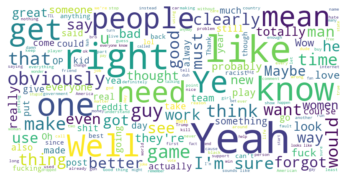

<Figure size 1152x864 with 0 Axes>

In [ ]:
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.figure(figsize=(16, 12))
plt.show()

In [ ]:
wordcloud = WordCloud(stopwords=stop_words_dict, max_font_size=100, max_words=200, background_color="white").generate(nonsarcastic_comments)

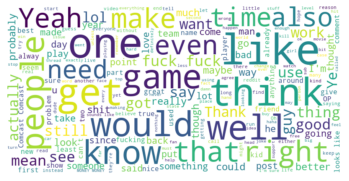

<Figure size 576x576 with 0 Axes>

In [ ]:
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.figure(figsize=(8,8))
plt.show()

In [ ]:
!pip install heatmapz

In [ ]:
from heatmap import heatmap, corrplot

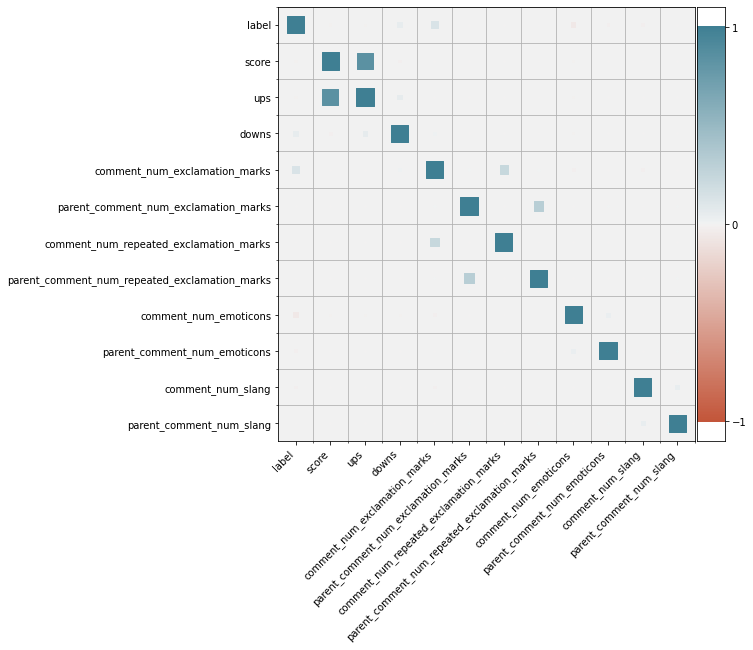

In [ ]:
plt.figure(figsize=(8, 8))
corrplot(training_csv_feature_engineering.corr(), size_scale=300);

In [ ]:
num_emoticons_comment = training_csv_feature_engineering.comment_num_emoticons
num_exclamation_mark = training_csv_feature_engineering.comment_num_exclamation_marks
num_rep_exclamation_mark = training_csv_feature_engineering.comment_num_repeated_exclamation_marks
num_slang = training_csv_feature_engineering.comment_num_slang


In [ ]:
training_csv_feature_engineering.to_csv('train_feature_engineering2.csv')
!cp train_feature_engineering2.csv "drive/My Drive/"

In [ ]:
## tokenize
training_csv_feature_engineering = remove_stopwords_and_tokenize_cols_in_dataset(
    training_csv_feature_engineering, COMMENT_AND_PARENT_COMMENT)

In [ ]:
## Add AFTER tokenization features
training_csv_feature_engineering = add_length_feature_to_dataset(
    training_csv_feature_engineering, COMMENT_AND_PARENT_COMMENT)

training_csv_feature_engineering = add_feature_history_to_train(
    training_csv_feature_engineering, AUTHOR)

training_csv_feature_engineering = add_feature_history_to_train(
    training_csv_feature_engineering, SUBREDDIT)

In [ ]:
## Normalise added features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() 
scaled_values = scaler.fit_transform(training_csv_feature_engineering.iloc[:, 10:]) 
training_csv_feature_engineering.iloc[:,10:] = scaled_values

In [ ]:
## Preview of features
## Engineered features from column 10 to end (0 based indexing)
training_csv_feature_engineering.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,comment_num_exclamation_marks,parent_comment_num_exclamation_marks,comment_num_repeated_exclamation_marks,parent_comment_num_repeated_exclamation_marks,comment_num_emoticons,parent_comment_num_emoticons,comment_num_slang,parent_comment_num_slang
0,0,"[NC, NH, .]",Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ...",0,0,0,0,0,0,0,0
1,0,"[You, know, west, teams, play, west, teams, ea...",Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...,0,0,0,0,0,0,0,0
2,0,"[They, underdogs, earlier, today, ,, since, Gr...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.,0,0,0,0,0,0,0,0
3,0,"[This, meme, n't, funny, none, ``, new, york, ...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz,0,0,0,0,0,0,0,0
4,0,"[I, could, use, one, tools, .]",cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...,0,0,0,0,0,0,0,0


In [ ]:
## for downloading df into csv for R visualisation
## training_csv_feature_engineering.to_csv (r'FOLDER_PATH\FILE_NAME.csv', index = False, header=True)